bundle_id가 있으면 무조건 bunlde로 보지 않고 part 1,2,5인 문항들은 독립문항으로 보고 분석한 버전

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# ============================================================
# Rasch Testlet (Bundle) + CJMLE-style (Optimized for Discrete Parts)
# Logit: P(y=1) = sigmoid(theta[u] - b[i] - gamma[t])
# If item is Part 1, 2, or 5 -> gamma[t] is forced to 0
# ============================================================

!pip -q install pyarrow pandas numpy tqdm

import os, math, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import pyarrow.dataset as ds

# ----------------------------
# 0) Settings & Paths
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

PARQ_PATH = "/content/drive/MyDrive/EdNET_KT/irt_long_first_with_bundle.parquet"
META_PATH = "/content/drive/MyDrive/EdNET_KT/analysis_q1_filtered.csv"

# ----------------------------
# 1) Load Metadata & Define Independent Parts
# ----------------------------
print("Loading metadata to identify independent parts (1, 2, 5)...")
df_meta = pd.read_csv(META_PATH)
# Part 1, 2, 5는 독립 문항으로 간주하여 번들 효과를 제외합니다.
independent_parts = {1, 2, 5}
independent_item_ids = set(df_meta[df_meta['part'].isin(independent_parts)]['question_id'].unique())

# ----------------------------
# 2) Build ID Maps (Streaming)
# ----------------------------
def build_index_maps(dataset, independent_items, batch_size=1_000_000):
    user_set, item_set, bundle_set = set(), set(), set()
    dataset = ds.dataset(PARQ_PATH, format="parquet")
    scanner = dataset.scanner(columns=["user_id", "item_id", "bundle_id"], batch_size=batch_size)

    for batch in tqdm(scanner.to_batches(), desc="Building ID maps"):
        df = batch.to_pandas()
        user_set.update(df["user_id"].dropna().unique())
        item_set.update(df["item_id"].dropna().unique())

        # [핵심] 독립 문항이 아닌 경우에만 번들 ID를 수집합니다.
        mask = ~df["item_id"].isin(independent_items)
        b_ids = df.loc[mask, "bundle_id"].dropna().unique()
        bundle_set.update(b_ids)

    users = sorted(user_set)
    items = sorted(item_set)
    bundles = sorted(bundle_set)

    u2i  = {u:idx for idx, u in enumerate(users)}
    it2i = {x:idx for idx, x in enumerate(items)}
    b2i  = {x:idx for idx, x in enumerate(bundles)}  # 독립 문항의 번들은 포함되지 않음

    return users, items, bundles, u2i, it2i, b2i

users, items, bundles, u2i, it2i, b2i = build_index_maps(ds.dataset(PARQ_PATH), independent_item_ids)

U, I, B = len(users), len(items), len(bundles)
print(f"\nFinal Structure: U={U}, I={I}, B(Bundled Only)={B}")

# ----------------------------
# 3) IRT Hyperparameters
# ----------------------------
MAX_ITERS = 30
BATCH_SIZE = 800_000
ETA_THETA, ETA_B, ETA_GAMMA = 0.0001, 0.0001, 0.0001
C_THETA, C_B, C_GAMMA = 25.0, 25.0, 4.0 # sqrt: 5, 5, 2

# ----------------------------
# 4) Initialization & Helpers
# ----------------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -20, 20)))

def center_params(theta, b, gamma):
    b -= b.mean()
    theta -= theta.mean()
    if gamma.size: gamma -= gamma.mean()
    return theta, b, gamma

def apply_constraints(theta, b, gamma):
    theta = np.clip(theta, -math.sqrt(C_THETA), math.sqrt(C_THETA)).astype(np.float32)
    b     = np.clip(b,     -math.sqrt(C_B),     math.sqrt(C_B)).astype(np.float32)
    if gamma.size:
        gamma = np.clip(gamma, -math.sqrt(C_GAMMA), math.sqrt(C_GAMMA)).astype(np.float32)
    return theta, b, gamma

theta = np.zeros(U, dtype=np.float32)
b     = np.zeros(I, dtype=np.float32)
gamma = np.zeros(B, dtype=np.float32)

# ----------------------------
# 5) Main Optimization Loop
# ----------------------------
dataset = ds.dataset(PARQ_PATH)

for it in range(1, MAX_ITERS + 1):
    g_theta = np.zeros(U, dtype=np.float64)
    g_b = np.zeros(I, dtype=np.float64)
    g_g = np.zeros(B, dtype=np.float64)

    scanner = dataset.scanner(columns=["user_id", "item_id", "bundle_id", "response"], batch_size=BATCH_SIZE)

    for batch in tqdm(scanner.to_batches(), desc=f"Iter {it}/{MAX_ITERS}", leave=False):
        df = batch.to_pandas()
        u_idx = df["user_id"].map(u2i).to_numpy(np.int32)
        i_idx = df["item_id"].map(it2i).to_numpy(np.int32)
        y = df["response"].to_numpy(np.float32)

        # [핵심] 독립 문항(Part 1,2,5)이면 번들 인덱스를 -1로 처리하여 gamma 업데이트 제외
        t_raw = df["bundle_id"].to_numpy()
        i_raw = df["item_id"].to_numpy()
        t_idx = np.array([b2i.get(tid, -1) if iid not in independent_item_ids else -1
                          for tid, iid in zip(t_raw, i_raw)], dtype=np.int32)

        has_gamma = (t_idx >= 0)

        # Logit calculation: theta - b - (gamma if exists)
        eta = theta[u_idx] - b[i_idx]
        if has_gamma.any():
            eta[has_gamma] -= gamma[t_idx[has_gamma]]

        p = sigmoid(eta)
        err = y - p # Gradient Ascent on Log-Likelihood

        np.add.at(g_theta, u_idx, err)
        np.add.at(g_b, i_idx, -err)
        if has_gamma.any():
            np.add.at(g_g, t_idx[has_gamma], -err[has_gamma])

    # Update parameters
    theta += ETA_THETA * g_theta.astype(np.float32)
    b     += ETA_B * g_b.astype(np.float32)
    if B > 0:
        gamma += ETA_GAMMA * g_g.astype(np.float32)

    # Identifiability & Constraints
    theta, b, gamma = center_params(theta, b, gamma)
    theta, b, gamma = apply_constraints(theta, b, gamma)

    print(f"[Iter {it}] max|g_theta|={np.max(np.abs(g_theta)):.2f}  "
          f"max|g_b|={np.max(np.abs(g_b)):.2f}  max|g_gamma|={np.max(np.abs(g_g)):.2f}")

# ----------------------------
# 6) Save & Export
# ----------------------------
pd.options.display.float_format = '{:.6f}'.format
SAVE_DIR = "/content/drive/MyDrive/EdNET_KT/part125_final_optimized/"
os.makedirs(SAVE_DIR, exist_ok=True)

pd.DataFrame({"item_id": items, "b": b}).to_csv(f"{SAVE_DIR}item_b_optimized.csv", index=False)
pd.DataFrame({"bundle_id": bundles, "gamma": gamma}).to_csv(f"{SAVE_DIR}bundle_gamma_optimized.csv", index=False)
pd.DataFrame({"user_id": users, "theta": theta}).to_csv(f"{SAVE_DIR}user_theta_optimized.csv", index=False)

print(f"\n 분석 완료! 모든 결과가 {SAVE_DIR}에 저장되었습니다.")

Loading metadata to identify independent parts (1, 2, 5)...


Building ID maps: 31it [00:17,  1.82it/s]



Final Structure: U=23477, I=11574, B(Bundled Only)=1220


[Iter 1] max|g_theta|=3678.00  max|g_b|=4480.50  max|g_gamma|=7106.00


[Iter 2] max|g_theta|=2845.60  max|g_b|=3207.16  max|g_gamma|=3544.13


[Iter 3] max|g_theta|=2242.78  max|g_b|=2403.91  max|g_gamma|=2619.54


[Iter 4] max|g_theta|=1806.89  max|g_b|=2017.13  max|g_gamma|=2060.36


[Iter 5] max|g_theta|=1485.63  max|g_b|=1709.99  max|g_gamma|=1695.74


[Iter 6] max|g_theta|=1287.21  max|g_b|=1466.65  max|g_gamma|=1442.15


[Iter 7] max|g_theta|=1127.67  max|g_b|=1271.64  max|g_gamma|=1273.49


[Iter 8] max|g_theta|=997.35  max|g_b|=1113.27  max|g_gamma|=1150.63


[Iter 9] max|g_theta|=889.46  max|g_b|=1018.45  max|g_gamma|=1050.28


[Iter 10] max|g_theta|=799.07  max|g_b|=938.95  max|g_gamma|=966.98


[Iter 11] max|g_theta|=722.50  max|g_b|=868.86  max|g_gamma|=896.86


[Iter 12] max|g_theta|=657.01  max|g_b|=806.84  max|g_gamma|=837.09


[Iter 13] max|g_theta|=602.26  max|g_b|=751.72  max|g_gamma|=785.58


[Iter 14] max|g_theta|=555.75  max|g_b|=702.53  max|g_gamma|=753.96


[Iter 15] max|g_theta|=517.51  max|g_b|=658.43  max|g_gamma|=726.27


[Iter 16] max|g_theta|=493.92  max|g_b|=618.74  max|g_gamma|=700.64


[Iter 17] max|g_theta|=472.06  max|g_b|=582.88  max|g_gamma|=676.87


[Iter 18] max|g_theta|=451.76  max|g_b|=550.37  max|g_gamma|=654.77


[Iter 19] max|g_theta|=432.88  max|g_b|=520.79  max|g_gamma|=634.19


[Iter 20] max|g_theta|=415.28  max|g_b|=493.79  max|g_gamma|=614.97


[Iter 21] max|g_theta|=398.85  max|g_b|=469.06  max|g_gamma|=597.01


[Iter 22] max|g_theta|=383.49  max|g_b|=446.36  max|g_gamma|=580.18


[Iter 23] max|g_theta|=370.47  max|g_b|=425.46  max|g_gamma|=564.38


[Iter 24] max|g_theta|=359.60  max|g_b|=406.17  max|g_gamma|=549.53


[Iter 25] max|g_theta|=349.22  max|g_b|=392.08  max|g_gamma|=535.55


[Iter 26] max|g_theta|=339.32  max|g_b|=382.15  max|g_gamma|=522.37


[Iter 27] max|g_theta|=329.85  max|g_b|=372.62  max|g_gamma|=509.92


[Iter 28] max|g_theta|=320.79  max|g_b|=363.50  max|g_gamma|=498.15


[Iter 29] max|g_theta|=312.13  max|g_b|=354.74  max|g_gamma|=487.00


[Iter 30] max|g_theta|=303.84  max|g_b|=346.33  max|g_gamma|=476.43

 분석 완료! 모든 결과가 /content/drive/MyDrive/EdNET_KT/part125_final_optimized/에 저장되었습니다.


결과 시각화

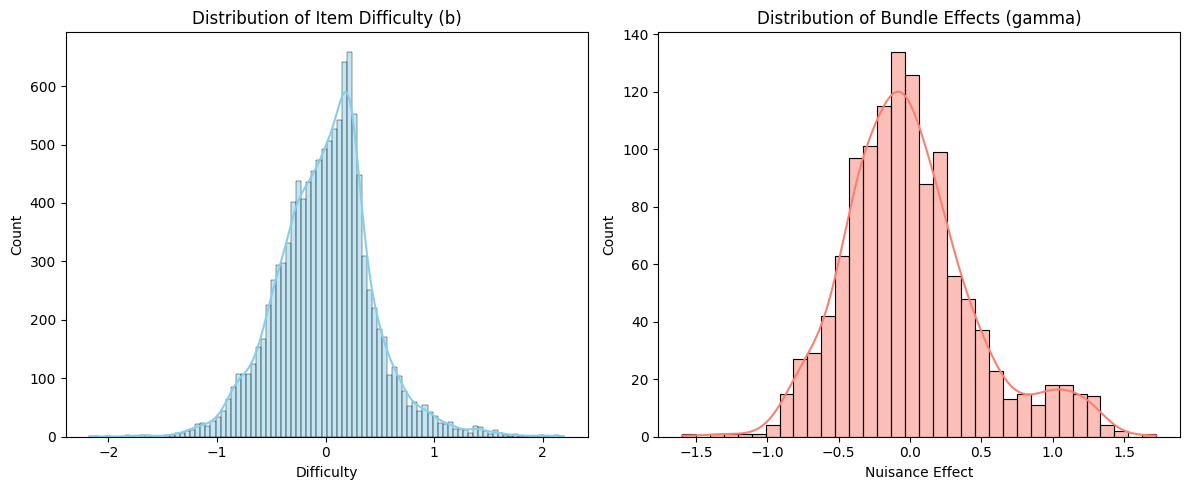

Item Difficulty Summary:
 count   11574.000000
mean        0.000000
std         0.443071
min        -2.174291
25%        -0.277631
50%         0.021166
75%         0.252465
max         2.193134
Name: b, dtype: float64

Bundle Effect Summary:
 count   1220.000000
mean      -0.000000
std        0.466021
min       -1.599549
25%       -0.307568
50%       -0.054256
75%        0.223700
max        1.724915
Name: gamma, dtype: float64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df_b = pd.read_csv("/content/drive/MyDrive/EdNET_KT/part125_final_optimized/item_b_optimized.csv")
df_g = pd.read_csv("/content/drive/MyDrive/EdNET_KT/part125_final_optimized/bundle_gamma_optimized.csv")

# 1. 문항 난이도(b) 분포 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_b['b'], kde=True, color='skyblue')
plt.title('Distribution of Item Difficulty (b)')
plt.xlabel('Difficulty')

# 2. 번들 효과(gamma) 분포 시각화
plt.subplot(1, 2, 2)
sns.histplot(df_g['gamma'], kde=True, color='salmon')
plt.title('Distribution of Bundle Effects (gamma)')
plt.xlabel('Nuisance Effect')

plt.tight_layout()
plt.show()

# 기초 통계량 확인
pd.options.display.float_format = '{:.6f}'.format
print("Item Difficulty Summary:\n", df_b['b'].describe())
print("\nBundle Effect Summary:\n", df_g['gamma'].describe())

bundle effect - item difficulty correlation -> 작아야 함.

원본 데이터에서 매핑 정보를 추출 중입니다...

 분석 완료!
문항 난이도(b)와 번들 효과(gamma)의 상관계수: 0.183198


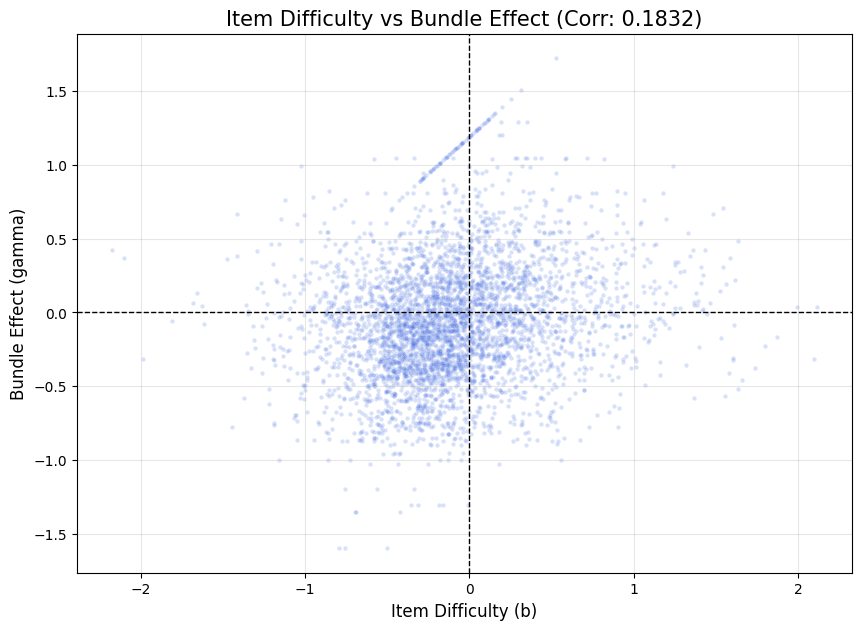

In [6]:
import pandas as pd
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 파일 경로 설정 (기존 설정 유지)
PARQ_PATH = "/content/drive/MyDrive/EdNET_KT/irt_long_first_with_bundle.parquet"
B_PATH = "/content/drive/MyDrive/EdNET_KT/part125_final_optimized/item_b_optimized.csv"
G_PATH = "/content/drive/MyDrive/EdNET_KT/part125_final_optimized/bundle_gamma_optimized.csv"

# 2. 결과 데이터 로드
df_b = pd.read_csv(B_PATH)
df_g = pd.read_csv(G_PATH)

# 3. [핵심] 원본 데이터에서 아이템-번들 매핑 정보 추출
print("원본 데이터에서 매핑 정보를 추출 중입니다...")
dataset = ds.dataset(PARQ_PATH, format="parquet")
# 필요한 컬럼만 스캔하여 고유한 쌍(item_id, bundle_id)만 가져옵니다.
item_bundle_map = dataset.scanner(columns=["item_id", "bundle_id"]).to_table().to_pandas().drop_duplicates()

# 4. 데이터 결합 (Merge)
# 아이템 난이도에 번들 ID를 붙이고, 그 번들 ID에 해당하는 감마 값을 붙입니다.
df_merged = df_b.merge(item_bundle_map, on='item_id').merge(df_g, on='bundle_id')

# 5. 상관계수 계산
correlation = df_merged['b'].corr(df_merged['gamma'])
print(f"\n 분석 완료!")
print(f"문항 난이도(b)와 번들 효과(gamma)의 상관계수: {correlation:.6f}")

# 6. 시각화 (산점도)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_merged, x='b', y='gamma', alpha=0.2, s=10, color='royalblue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title(f'Item Difficulty vs Bundle Effect (Corr: {correlation:.4f})', fontsize=15)
plt.xlabel('Item Difficulty (b)', fontsize=12)
plt.ylabel('Bundle Effect (gamma)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()